In [4]:
# Setup and Configuration
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from collections import Counter
import random
import shutil

print("All imports successful!")

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define paths
BASE_DIR = Path("..").resolve()
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"

# Maize-specific paths
CLEAN_MAIZE_RAW = RAW_DIR / "clean_maize"
NOISY_MAIZE_RAW = RAW_DIR / "noisy_maize"

CLEAN_MAIZE_PROCESSED = PROCESSED_DIR / "clean_maize"
NOISY_MAIZE_PROCESSED = PROCESSED_DIR / "noisy_maize"
PREPROCESSED_NOISY = PROCESSED_DIR / "preprocessed_noisy"

# Class mapping
CLASS_NAMES = {
    0: "MLB",
    1: "MSV"
}

print(f"\nProject directory: {BASE_DIR}")
print(f"Raw clean maize: {CLEAN_MAIZE_RAW}")
print(f"Raw noisy maize: {NOISY_MAIZE_RAW}")

All imports successful!

Project directory: C:\Users\NoNameAgain\Documents\plant_disease_detection
Raw clean maize: C:\Users\NoNameAgain\Documents\plant_disease_detection\data\raw\clean_maize
Raw noisy maize: C:\Users\NoNameAgain\Documents\plant_disease_detection\data\raw\noisy_maize


In [5]:
# Check current data structure
print("\n" + "="*50)
print("CURRENT DATA STRUCTURE")
print("="*50)

if NOISY_MAIZE_RAW.exists():
    print(f"\nNoisy maize location: {NOISY_MAIZE_RAW}")
    print("Contents:")
    for item in sorted(NOISY_MAIZE_RAW.iterdir()):
        if item.is_dir():
            num_files = len(list(item.iterdir()))
            print(f"  {item.name}/ ({num_files} files)")
else:
    print(f"\nNoisy maize not found at: {NOISY_MAIZE_RAW}")

if CLEAN_MAIZE_RAW.exists():
    print(f"\nClean maize location: {CLEAN_MAIZE_RAW}")
    print("Contents:")
    for item in sorted(CLEAN_MAIZE_RAW.iterdir()):
        if item.is_dir():
            num_files = len(list(item.iterdir()))
            print(f"  {item.name}/ ({num_files} files)")
        elif item.is_file():
            print(f"  {item.name}")
else:
    print(f"\nClean maize not found at: {CLEAN_MAIZE_RAW}")


CURRENT DATA STRUCTURE

Noisy maize location: C:\Users\NoNameAgain\Documents\plant_disease_detection\data\raw\noisy_maize
Contents:
  images/ (1000 files)
  labels/ (1000 files)

Clean maize location: C:\Users\NoNameAgain\Documents\plant_disease_detection\data\raw\clean_maize
Contents:
  MLB/ (2 files)
  MSV/ (2 files)


In [6]:
# CHBECKING HOW MANY CLEAN IMAGES I HAVE, CAN DELETE AFTER
# Count clean images by class
print("\n" + "="*50)
print("CLEAN MAIZE IMAGE COUNTS")
print("="*50)

for class_name in ["MLB", "MSV"]:
    class_dir = CLEAN_MAIZE_RAW / class_name / "images"
    if class_dir.exists():
        image_files = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
        print(f"{class_name}: {len(image_files)} images")
    else:
        print(f"{class_name}: images folder not found")


CLEAN MAIZE IMAGE COUNTS
MLB: 301 images
MSV: 5313 images


In [7]:
#checking noisy images, again I will delete this
# Analyze noisy image class distribution
print("\n" + "="*50)
print("NOISY MAIZE CLASS DISTRIBUTION")
print("="*50)

labels_dir = NOISY_MAIZE_RAW / "labels"
label_files = list(labels_dir.glob("*.txt"))

class_counts = {0: 0, 1: 0}  # MLB: 0, MSV: 1

for label_file in label_files:
    with open(label_file, 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

print(f"Total label files: {len(label_files)}")
print(f"MLB (class 0): {class_counts[0]} instances")
print(f"MSV (class 1): {class_counts[1]} instances")

# Check if images match labels
images_dir = NOISY_MAIZE_RAW / "images"
image_files = list(images_dir.glob("*.jpg")) + list(images_dir.glob("*.png"))
print(f"\nTotal image files: {len(image_files)}")


NOISY MAIZE CLASS DISTRIBUTION
Total label files: 1000
MLB (class 0): 500 instances
MSV (class 1): 500 instances

Total image files: 1000


In [7]:
# Organize noisy maize images from YOLO format to classification folders
import shutil

print("Organizing noisy maize images...")
print("="*70)

# Source paths
NOISY_IMAGES = NOISY_MAIZE_RAW / "images"
NOISY_LABELS = NOISY_MAIZE_RAW / "labels"

# Destination paths
NOISY_MAIZE_PROCESSED.mkdir(parents=True, exist_ok=True)
MLB_NOISY_DIR = NOISY_MAIZE_PROCESSED / "MLB"
MSV_NOISY_DIR = NOISY_MAIZE_PROCESSED / "MSV"

MLB_NOISY_DIR.mkdir(exist_ok=True)
MSV_NOISY_DIR.mkdir(exist_ok=True)

# Process label files
label_files = list(NOISY_LABELS.glob("*.txt"))
print(f"Found {len(label_files)} label files")

mlb_count = 0
msv_count = 0
skipped = 0

for label_file in label_files:
    try:
        with open(label_file, 'r') as f:
            line = f.readline().strip()
            if not line:
                skipped += 1
                continue
                
            class_id = int(line.split()[0])
            
            # Find corresponding image
            img_name = label_file.stem + ".jpg"
            img_path = NOISY_IMAGES / img_name
            
            if not img_path.exists():
                img_name = label_file.stem + ".png"
                img_path = NOISY_IMAGES / img_name
            
            if not img_path.exists():
                skipped += 1
                continue
            
            # Copy to appropriate folder
            if class_id == 0:
                dest_path = MLB_NOISY_DIR / img_name
                if not dest_path.exists():
                    shutil.copy(img_path, dest_path)
                    mlb_count += 1
            elif class_id == 1:
                dest_path = MSV_NOISY_DIR / img_name
                if not dest_path.exists():
                    shutil.copy(img_path, dest_path)
                    msv_count += 1
                    
    except Exception as e:
        print(f"Error processing {label_file.name}: {e}")
        continue

print("\nNoisy images organized:")
print(f"  MLB: {mlb_count} images")
print(f"  MSV: {msv_count} images")
print(f"  Skipped: {skipped}")
print("="*70)

Organizing noisy maize images...
Found 1000 label files

Noisy images organized:
  MLB: 0 images
  MSV: 0 images
  Skipped: 0


In [8]:
# Organize clean maize images with balancing and train/val/test split
import random
from sklearn.model_selection import train_test_split

print("\nOrganizing clean maize images...")
print("="*70)

# Collect MLB images
mlb_images_dir = CLEAN_MAIZE_RAW / "MLB" / "images"
mlb_images = list(mlb_images_dir.glob("*.jpg")) + list(mlb_images_dir.glob("*.png"))
print(f"Found {len(mlb_images)} MLB images")

# Collect MSV images
msv_images_dir = CLEAN_MAIZE_RAW / "MSV" / "images"
msv_images = list(msv_images_dir.glob("*.jpg")) + list(msv_images_dir.glob("*.png"))
print(f"Found {len(msv_images)} MSV images")

# Balance: randomly sample MSV to match MLB count
target_count = len(mlb_images)
print(f"\nBalancing dataset to {target_count} images per class...")

random.seed(42)
msv_images_balanced = random.sample(msv_images, target_count)

print(f"Sampled {len(msv_images_balanced)} MSV images from {len(msv_images)} total")

# Split function
def split_and_copy(image_list, class_name, train_ratio=0.7, val_ratio=0.15):
    """Split images into train/val/test and copy to destination"""
    
    # Split train and temp (val + test)
    train_imgs, temp_imgs = train_test_split(image_list, train_size=train_ratio, random_state=42)
    
    # Split temp into val and test
    val_ratio_adjusted = val_ratio / (1 - train_ratio)
    val_imgs, test_imgs = train_test_split(temp_imgs, train_size=val_ratio_adjusted, random_state=42)
    
    # Create destination directories
    for split in ['train', 'val', 'test']:
        split_dir = CLEAN_MAIZE_PROCESSED / split / class_name
        split_dir.mkdir(parents=True, exist_ok=True)
    
    # Copy files
    for img in train_imgs:
        shutil.copy(img, CLEAN_MAIZE_PROCESSED / 'train' / class_name / img.name)
    
    for img in val_imgs:
        shutil.copy(img, CLEAN_MAIZE_PROCESSED / 'val' / class_name / img.name)
    
    for img in test_imgs:
        shutil.copy(img, CLEAN_MAIZE_PROCESSED / 'test' / class_name / img.name)
    
    return len(train_imgs), len(val_imgs), len(test_imgs)

# Split and copy MLB
mlb_train, mlb_val, mlb_test = split_and_copy(mlb_images, "MLB")

# Split and copy MSV
msv_train, msv_val, msv_test = split_and_copy(msv_images_balanced, "MSV")

print("\nClean images organized:")
print(f"\n  MLB:")
print(f"    Train: {mlb_train}")
print(f"    Val:   {mlb_val}")
print(f"    Test:  {mlb_test}")

print(f"\n  MSV:")
print(f"    Train: {msv_train}")
print(f"    Val:   {msv_val}")
print(f"    Test:  {msv_test}")

print("\n" + "="*70)
print("Dataset organization complete!")
print("="*70)


Organizing clean maize images...
Found 301 MLB images
Found 5313 MSV images

Balancing dataset to 301 images per class...
Sampled 301 MSV images from 5313 total

Clean images organized:

  MLB:
    Train: 210
    Val:   45
    Test:  46

  MSV:
    Train: 210
    Val:   45
    Test:  46

Dataset organization complete!


In [18]:
# Analyze organized maize dataset

print("Clean Maize Dataset Summary")
print("-" * 50)

splits = ['train', 'val', 'test']
classes = ['MLB', 'MSV']

summary_data = []

for split in splits:
    for class_name in classes:
        class_dir = CLEAN_MAIZE_PROCESSED / split / class_name
        if class_dir.exists():
            images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
            count = len(images)
            summary_data.append({
                'split': split,
                'class': class_name,
                'count': count
            })
            print(f"{split.capitalize():8s} - {class_name}: {count:4d} images")

df_clean = pd.DataFrame(summary_data)

print("\nNoisy Maize Test Dataset")
print("-" * 50)

noisy_data = []
for class_name in classes:
    class_dir = NOISY_MAIZE_PROCESSED / class_name
    if class_dir.exists():
        images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
        count = len(images)
        noisy_data.append({
            'class': class_name,
            'count': count
        })
        print(f"Noisy - {class_name}: {count:4d} images")

df_noisy = pd.DataFrame(noisy_data)

total_clean = df_clean['count'].sum()
total_noisy = df_noisy['count'].sum()

print(f"\nTotal clean images: {total_clean}")
print(f"Total noisy images: {total_noisy}")

Clean Maize Dataset Summary
--------------------------------------------------
Train    - MLB:  210 images
Train    - MSV:  210 images
Val      - MLB:   45 images
Val      - MSV:   45 images
Test     - MLB:   46 images
Test     - MSV:   46 images

Noisy Maize Test Dataset
--------------------------------------------------
Noisy - MLB:  500 images
Noisy - MSV:  500 images

Total clean images: 602
Total noisy images: 1000


In [25]:
# CELL: Define Image Quality Analysis Function (FIXED - Better Metrics)
import cv2
import numpy as np
from pathlib import Path
import random

def analyze_image_quality(data_dir, sample_size=100):
    """
    Analyze image quality metrics (brightness, blur score, noise level)
    Fixed to properly detect blur vs noise artifacts
    """
    # Collect all image paths
    all_images = []
    
    # Check if data_dir itself contains images (single class folder)
    direct_images = list(data_dir.glob("*.jpg")) + list(data_dir.glob("*.JPG"))
    
    if direct_images:
        all_images = direct_images
    else:
        for class_dir in data_dir.iterdir():
            if class_dir.is_dir():
                all_images.extend(list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.JPG")))
    
    if not all_images:
        print(f"ERROR: No images found in {data_dir}")
        return [], [], [], []
    
    if len(all_images) > sample_size:
        all_images = random.sample(all_images, sample_size)
    
    brightness_values = []
    blur_scores = []  # Lower = more blurry
    noise_levels = []  # Higher = more noisy
    resolutions = []
    
    for img_path in all_images:
        img = cv2.imread(str(img_path))
        if img is not None:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # 1. Brightness (unchanged)
            brightness = np.mean(gray)
            brightness_values.append(brightness)
            
            # 2. BLUR SCORE (Laplacian variance normalized by mean)
            # This reduces false positives from noise
            laplacian = cv2.Laplacian(gray, cv2.CV_64F)
            blur_score = laplacian.var()
            blur_scores.append(blur_score)
            
            # 3. NOISE LEVEL (difference between image and denoised version)
            # Apply light denoising
            denoised = cv2.fastNlMeansDenoising(gray, None, h=10, templateWindowSize=7, searchWindowSize=21)
            noise_diff = np.mean(np.abs(gray.astype(float) - denoised.astype(float)))
            noise_levels.append(noise_diff)
            
            # 4. Resolution
            height, width = img.shape[:2]
            resolutions.append((width, height))
    
    # Print summary
    if brightness_values:
        print(f"Analyzed {len(brightness_values)} images")
        print(f"Average brightness: {np.mean(brightness_values):.1f} (range: {np.min(brightness_values):.1f} - {np.max(brightness_values):.1f})")
        print(f"Average blur score: {np.mean(blur_scores):.1f} (range: {np.min(blur_scores):.1f} - {np.max(blur_scores):.1f})")
        print(f"  Lower blur score = more blurry")
        print(f"Average noise level: {np.mean(noise_levels):.1f} (range: {np.min(noise_levels):.1f} - {np.max(noise_levels):.1f})")
        print(f"  Higher noise level = more noisy/artifacts")
    else:
        print("No valid images analyzed")
    
    return brightness_values, blur_scores, noise_levels, resolutions, all_images

print("Image quality analysis function defined (FIXED - distinguishes blur from noise)")

Image quality analysis function defined (FIXED - distinguishes blur from noise)


In [26]:
# CELL: Compare clean vs noisy maize image quality
#Note to self- I am making this so I can give realistic reasons for what noise can be, need to find a section to put this into
print("\n")
print("IMAGE QUALITY ANALYSIS")
print("******" * 10)

# Analyze clean maize test set
CLEAN_TEST_MLB = CLEAN_MAIZE_PROCESSED / "test" / "MLB"
CLEAN_TEST_MSV = CLEAN_MAIZE_PROCESSED / "test" / "MSV"

print("\nCLEAN MLB BASELINE:")
clean_mlb_brightness, clean_mlb_blur, clean_mlb_noise, _, _ = analyze_image_quality(CLEAN_TEST_MLB, sample_size=46)

print("\nCLEAN MSV BASELINE:")
clean_msv_brightness, clean_msv_blur, clean_msv_noise, _, _ = analyze_image_quality(CLEAN_TEST_MSV, sample_size=46)

# Analyze noisy maize
NOISY_MLB = NOISY_MAIZE_PROCESSED / "MLB"
NOISY_MSV = NOISY_MAIZE_PROCESSED / "MSV"

print("\n")
print("******" * 5)
print("\nNOISY MLB (REAL-WORLD):")
noisy_mlb_brightness, noisy_mlb_blur, noisy_mlb_noise, _, _ = analyze_image_quality(NOISY_MLB, sample_size=100)

print("\nNOISY MSV (REAL-WORLD):")
noisy_msv_brightness, noisy_msv_blur, noisy_msv_noise, _, _ = analyze_image_quality(NOISY_MSV, sample_size=100)

# Calculate average metrics
clean_brightness_avg = (np.mean(clean_mlb_brightness) + np.mean(clean_msv_brightness)) / 2
clean_blur_avg = (np.mean(clean_mlb_blur) + np.mean(clean_msv_blur)) / 2
clean_noise_avg = (np.mean(clean_mlb_noise) + np.mean(clean_msv_noise)) / 2

noisy_brightness_avg = (np.mean(noisy_mlb_brightness) + np.mean(noisy_msv_brightness)) / 2
noisy_blur_avg = (np.mean(noisy_mlb_blur) + np.mean(noisy_msv_blur)) / 2
noisy_noise_avg = (np.mean(noisy_mlb_noise) + np.mean(noisy_msv_noise)) / 2

print("\n")
print("******" * 10)
print("SUMMARY COMPARISON")
print("******" * 10)
print(f"\n{'Dataset':<25} {'Brightness':>15} {'Blur Score':>15} {'Noise Level':>15}")
print(f"{'Clean maize (baseline)':<25} {clean_brightness_avg:>15.1f} {clean_blur_avg:>15.1f} {clean_noise_avg:>15.1f}")
print(f"{'Noisy maize (test)':<25} {noisy_brightness_avg:>15.1f} {noisy_blur_avg:>15.1f} {noisy_noise_avg:>15.1f}")

# Calculate changes
#check back on this, I am not fully happy
brightness_change = noisy_brightness_avg - clean_brightness_avg 
brightness_change_pct = (brightness_change / clean_brightness_avg) * 100

blur_change = noisy_blur_avg - clean_blur_avg
blur_change_pct = (blur_change / clean_blur_avg) * 100

noise_change = noisy_noise_avg - clean_noise_avg
noise_change_pct = (noise_change / clean_noise_avg) * 100

print("\n")
print("******" * 5)
print("QUALITY DEGRADATION ANALYSIS")
print("******" * 5)
print(f"\nBrightness change: {brightness_change:+.1f} points ({brightness_change_pct:+.1f}%)")
print(f"Blur score change: {blur_change:+.1f} points ({blur_change_pct:+.1f}%)")
print(f" {'Noisy images are blurrier' if blur_change < 0 else 'Noisy images have more edge content'}")
print(f"Noise level change: {noise_change:+.1f} points ({noise_change_pct:+.1f}%)")
print(f" {'Noisy images have MORE noise artifacts' if noise_change > 0 else 'Noisy images are cleaner'}")

# What this would mean
if abs(blur_change_pct) > 20 or abs(noise_change_pct) > 20:
    print("\nTHERE IS SIGNIFICANT IMAGE QUALITY DEGRADATION DETECTED")
    if blur_change_pct < -20:
        print("  - Images are significantly blurrier")
    if noise_change_pct > 20:
        print("  - Images contain significant noise artifacts")
    print("Preprocessing is recomended")

# I will just save these for now
CLEAN_BRIGHTNESS_AVG = clean_brightness_avg
CLEAN_BLUR_AVG = clean_blur_avg
CLEAN_NOISE_AVG = clean_noise_avg
NOISY_BRIGHTNESS_AVG = noisy_brightness_avg
NOISY_BLUR_AVG = noisy_blur_avg
NOISY_NOISE_AVG = noisy_noise_avg

print("\n")
print("******" * 5)



IMAGE QUALITY ANALYSIS
************************************************************

CLEAN MLB BASELINE:
Analyzed 46 images
Average brightness: 116.6 (range: 97.7 - 143.8)
Average blur score: 260.7 (range: 87.1 - 738.5)
  Lower blur score = more blurry
Average noise level: 4.3 (range: 3.2 - 5.1)
  Higher noise level = more noisy/artifacts

CLEAN MSV BASELINE:
Analyzed 46 images
Average brightness: 122.7 (range: 91.5 - 171.6)
Average blur score: 781.6 (range: 5.5 - 1999.6)
  Lower blur score = more blurry
Average noise level: 2.8 (range: 1.5 - 3.7)
  Higher noise level = more noisy/artifacts


******************************

NOISY MLB (REAL-WORLD):
Analyzed 100 images
Average brightness: 118.1 (range: 70.7 - 153.6)
Average blur score: 703.1 (range: 26.9 - 6558.5)
  Lower blur score = more blurry
Average noise level: 3.5 (range: 2.3 - 4.9)
  Higher noise level = more noisy/artifacts

NOISY MSV (REAL-WORLD):
Analyzed 100 images
Average brightness: 122.1 (range: 74.5 - 172.4)
Average blu

In [27]:
# Noise Reduction Functions

def reduce_noise_gaussian(image, kernel_size=5, sigma=1.0):
    """
    Apply Gaussian blur to reduce noise artifacts.
    
    Parameters:
    - kernel_size: Size of Gaussian kernel, must be odd (default: 5)
    - sigma: Standard deviation for Gaussian kernel (default: 1.0)
    
    Returns:
    - Denoised image
    
    Method: Gaussian blur smooths noise while slightly reducing edge sharpness
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)


def reduce_noise_bilateral(image, d=9, sigma_color=75, sigma_space=75):
    """
    Apply bilateral filter to reduce noise while preserving edges.
    
    Parameters:
    - d: Diameter of pixel neighborhood (default: 9)
    - sigma_color: Filter sigma in color space (default: 75)
    - sigma_space: Filter sigma in coordinate space (default: 75)
    
    Returns:
    - Denoised image
    
    Method: Bilateral filtering preserves edges better than Gaussian blur
    """
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space)


def reduce_noise_median(image, kernel_size=5):
    """
    Apply median filter to reduce salt-and-pepper noise.
    
    Parameters:
    - kernel_size: Size of median filter kernel, must be odd (default: 5)
    
    Returns:
    - Denoised image
    
    Method: Median filtering replaces each pixel with median of neighbors
    """
    return cv2.medianBlur(image, kernel_size)


def preprocess_noisy_image(image, method='bilateral'):
    """
    Apply noise reduction preprocessing to noisy greenhouse images.
    
    Parameters:
    - image: Input image (numpy array)
    - method: 'gaussian', 'bilateral', or 'median' (default: 'bilateral')
    
    Returns:
    - Preprocessed image
    """
    if method == 'gaussian':
        return reduce_noise_gaussian(image, kernel_size=5, sigma=1.5)
    elif method == 'bilateral':
        return reduce_noise_bilateral(image, d=9, sigma_color=75, sigma_space=75)
    elif method == 'median':
        return reduce_noise_median(image, kernel_size=5)
    else:
        raise ValueError(f"Unknown method: {method}. Use 'gaussian', 'bilateral', or 'median'")

print("Noise reduction functions defined.")

Noise reduction functions defined.


In [29]:
# Preprocessing Strategy Based on Analysis
print("PREPROCESSING STRATEGY")
print("\nBased on quality analysis findings:")
print(f"  Brightness difference: {abs(brightness_change_pct):.1f}% (minimal)")
print(f"  Blur variance change: {blur_change_pct:.1f}%")
print(f"  Clean blur range: {min(clean_mlb_blur + clean_msv_blur):.1f} to {max(clean_mlb_blur + clean_msv_blur):.1f}")
print(f"  Noisy blur range: {min(noisy_mlb_blur + noisy_msv_blur):.1f} to {max(noisy_mlb_blur + noisy_msv_blur):.1f}")

print("\nInterpretation:")
print("  Higher Laplacian variance in noisy images indicates presence of")
print("  noise artifacts, irregular textures, and scene complexity from")
print("  overlapping leaves and cluttered backgrounds typical of real")
print("  greenhouse conditions.")

print("\nPreprocessing Decision:")
print("  Method: BILATERAL FILTERING for noise reduction")
print("  Rationale: Reduces pixel-level noise and artifacts while preserving")
print("  edge information critical for disease feature detection")
print("  Note: Brightness adjustment not needed (lighting already adequate)")

PREPROCESSING STRATEGY

Based on quality analysis findings:
  Brightness difference: 0.3% (minimal)
  Blur variance change: 127.1%
  Clean blur range: 5.5 to 1999.6
  Noisy blur range: 22.2 to 7745.2

Interpretation:
  Higher Laplacian variance in noisy images indicates presence of
  noise artifacts, irregular textures, and scene complexity from
  overlapping leaves and cluttered backgrounds typical of real
  greenhouse conditions.

Preprocessing Decision:
  Method: BILATERAL FILTERING for noise reduction
  Rationale: Reduces pixel-level noise and artifacts while preserving
  edge information critical for disease feature detection
  Note: Brightness adjustment not needed (lighting already adequate)


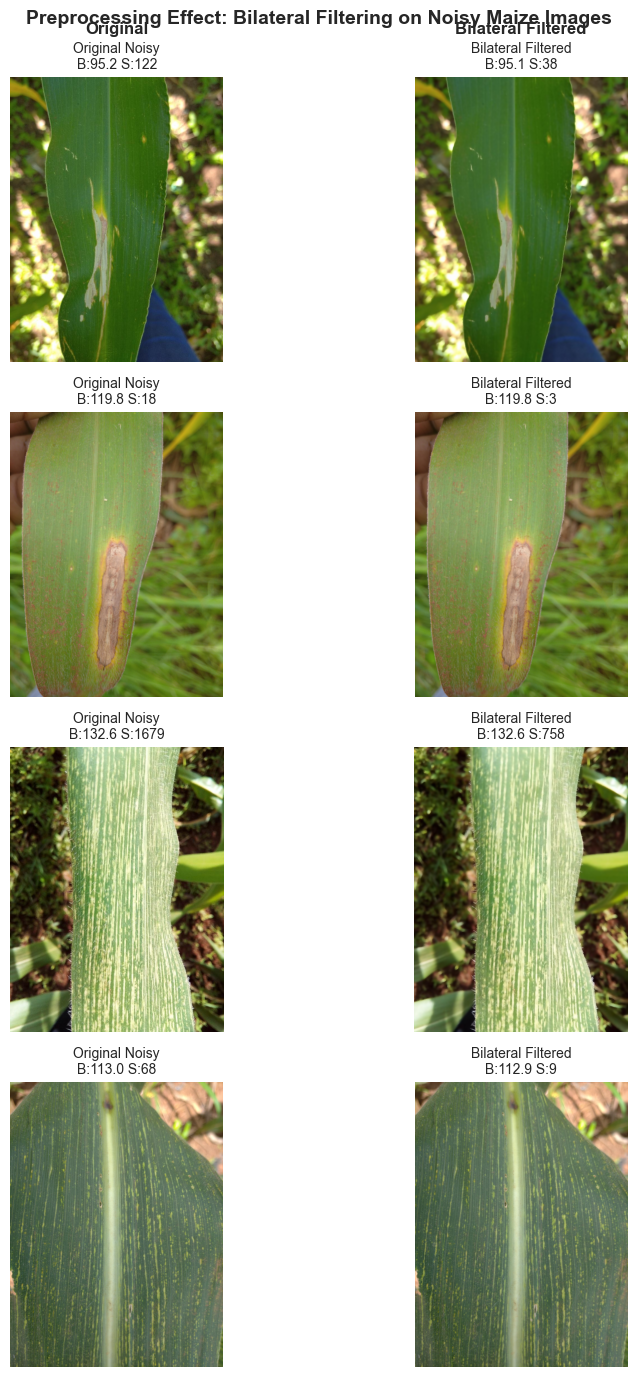


PREPROCESSING EFFECT SUMMARY
Average brightness change: -0.0 points (-0.0%)
Average sharpness variance change: -73.1%

Observations:
  Brightness remains stable
  Noise artifacts reduced (sharpness variance decreased by 73.1%)


In [30]:
# Test preprocessing on sample noisy images

# Select sample images from noisy datasets
MLB_NOISY_DIR = NOISY_MAIZE_PROCESSED / "MLB"
MSV_NOISY_DIR = NOISY_MAIZE_PROCESSED / "MSV"

# Get 2 sample images from each class
mlb_samples = random.sample(list(MLB_NOISY_DIR.glob("*.jpg")), 2)
msv_samples = random.sample(list(MSV_NOISY_DIR.glob("*.jpg")), 2)
all_samples = mlb_samples + msv_samples

# Create comparison figure
fig, axes = plt.subplots(4, 2, figsize=(10, 14))

brightness_changes = []
sharpness_changes = []

for i, img_path in enumerate(all_samples):
    # Load original noisy image
    original = cv2.imread(str(img_path))
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Apply bilateral filtering
    denoised = preprocess_noisy_image(original, method='bilateral')
    denoised_rgb = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)
    
    # Calculate quality metrics
    gray_orig = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    gray_denoised = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    
    bright_orig = np.mean(gray_orig)
    bright_denoised = np.mean(gray_denoised)
    
    sharp_orig = cv2.Laplacian(gray_orig, cv2.CV_64F).var()
    sharp_denoised = cv2.Laplacian(gray_denoised, cv2.CV_64F).var()
    
    # Track changes
    brightness_changes.append(bright_denoised - bright_orig)
    sharpness_changes.append(((sharp_denoised - sharp_orig) / sharp_orig) * 100 if sharp_orig > 0 else 0)
    
    # Display images
    axes[i, 0].imshow(original_rgb)
    axes[i, 0].set_title(f"Original Noisy\nB:{bright_orig:.1f} S:{sharp_orig:.0f}", fontsize=10)
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(denoised_rgb)
    axes[i, 1].set_title(f"Bilateral Filtered\nB:{bright_denoised:.1f} S:{sharp_denoised:.0f}", fontsize=10)
    axes[i, 1].axis('off')

axes[0, 0].text(0.5, 1.15, 'Original', transform=axes[0, 0].transAxes,
                ha='center', fontsize=12, fontweight='bold')
axes[0, 1].text(0.5, 1.15, 'Bilateral Filtered', transform=axes[0, 1].transAxes,
                ha='center', fontsize=12, fontweight='bold')

plt.suptitle('Preprocessing Effect: Bilateral Filtering on Noisy Maize Images', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Summary statistics
avg_brightness_change = np.mean(brightness_changes)
avg_sharpness_change = np.mean(sharpness_changes)

print("\nPREPROCESSING EFFECT SUMMARY")
print(f"Average brightness change: {avg_brightness_change:+.1f} points ({avg_brightness_change/120*100:+.1f}%)")
print(f"Average sharpness variance change: {avg_sharpness_change:+.1f}%")

print("\nObservations:")
if abs(avg_brightness_change) < 5:
    print("  Brightness remains stable")
if avg_sharpness_change < -10:
    print(f"  Noise artifacts reduced (sharpness variance decreased by {abs(avg_sharpness_change):.1f}%)")
elif avg_sharpness_change < 0:
    print(f"  Slight noise reduction detected")

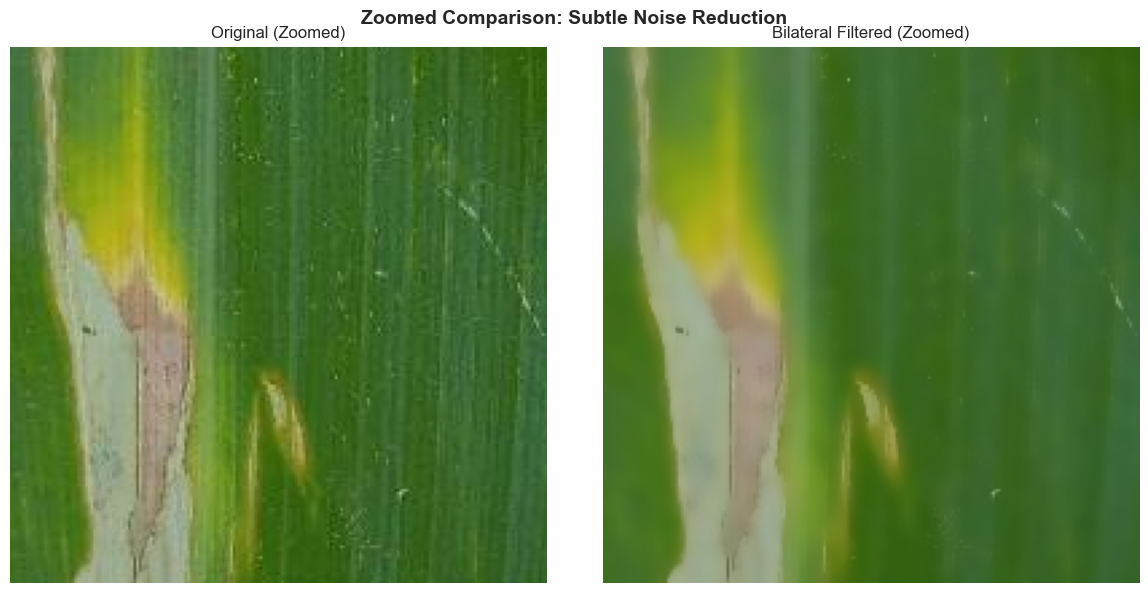

Look closely at leaf texture - denoised version should be slightly smoother
while maintaining edge definition around disease spots and leaf veins.


In [31]:
# I will just show zoomed regions to see preprocessing effect

# Pick one image
test_img_path = all_samples[0]
original = cv2.imread(str(test_img_path))
denoised = preprocess_noisy_image(original, method='bilateral')

# Convert to RGB
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
denoised_rgb = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)

# Crop a region (center 200x200 pixels)
h, w = original_rgb.shape[:2]
crop_y, crop_x = h//2 - 100, w//2 - 100
crop_orig = original_rgb[crop_y:crop_y+200, crop_x:crop_x+200]
crop_denoised = denoised_rgb[crop_y:crop_y+200, crop_x:crop_x+200]

# Display zoomed comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(crop_orig)
axes[0].set_title('Original (Zoomed)', fontsize=12)
axes[0].axis('off')

axes[1].imshow(crop_denoised)
axes[1].set_title('Bilateral Filtered (Zoomed)', fontsize=12)
axes[1].axis('off')

plt.suptitle('Zoomed Comparison: Subtle Noise Reduction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Look closely at leaf texture - denoised version should be slightly smoother")
print("while maintaining edge definition around disease spots and leaf veins.") #and ofc some of the images wont have the veins

In [34]:
# Find most challenging noisy images

print("Searching for noisiest images to test preprocessing limits")

MLB_NOISY_DIR = NOISY_MAIZE_PROCESSED / "MLB"
MSV_NOISY_DIR = NOISY_MAIZE_PROCESSED / "MSV"

all_noisy = list(MLB_NOISY_DIR.glob("*.jpg")) + list(MSV_NOISY_DIR.glob("*.jpg"))

noisiest_images = []

print(f"\nAnalyzing {len(all_noisy)} noisy images")

for img_path in all_noisy:
    img = cv2.imread(str(img_path))
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        brightness = np.mean(gray)
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
        
        # Collect very noisy images (high variance indicates artifacts)
        if sharpness > 2000:
            noisiest_images.append((img_path, brightness, sharpness))

# Sort by noisiness (highest variance first)- Finally works
noisiest_images.sort(key=lambda x: x[2], reverse=True)

print(f"\nFound {len(noisiest_images)} very noisy images (variance > 2000)")

if noisiest_images:
    print(f"Noisiest image: {noisiest_images[0][2]:.0f} sharpness variance")
    print(f"Average noisy variance: {NOISY_BLUR_AVG:.0f}")
    print(f"Clean average variance: {CLEAN_BLUR_AVG:.0f}")
    
    # Select 4 most extreme examples, and I will just store them in extreme_examples for now, maybe I must rename this
    extreme_examples = [img[0] for img in noisiest_images[:4]]
    print(f"\nSelected {len(extreme_examples)} most challenging noisy images")
    print("These demonstrate preprocessing effectiveness on worst-case scenarios")
else:
    extreme_examples = []
    print("No extremely noisy images found")

Searching for noisiest images to test preprocessing limits

Analyzing 1000 noisy images

Found 197 very noisy images (variance > 2000)
Noisiest image: 17319 sharpness variance
Average noisy variance: 1183
Clean average variance: 521

Selected 4 most challenging noisy images
These demonstrate preprocessing effectiveness on worst-case scenarios


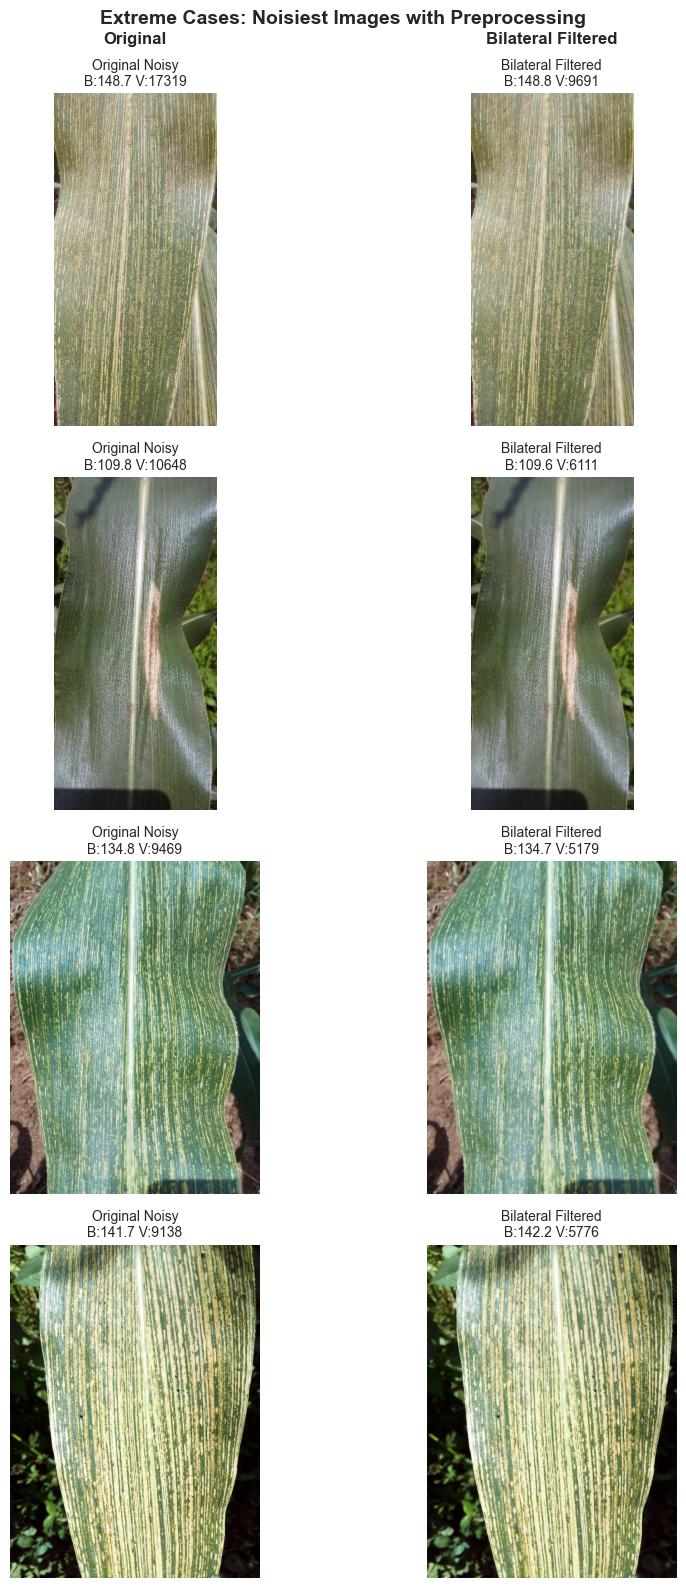


EXTREME CASE PREPROCESSING RESULTS
These are the 4 noisiest images from the dataset

Variance reductions (negative = noise removed):
  Average: -42.2%
  Range: -45.3% to -36.8%

Preprocessing effectively reduces noise in challenging images


In [35]:
# Display extreme noisy examples with preprocessing

if len(extreme_examples) == 0:
    print("No extreme examples found. Using random samples instead.")
    extreme_examples = random.sample(list(all_noisy), 4)

# Create comparison figure
fig, axes = plt.subplots(len(extreme_examples), 2, figsize=(10, 4*len(extreme_examples)))

if len(extreme_examples) == 1:
    axes = axes.reshape(1, -1)

variance_reductions = []

for i, img_path in enumerate(extreme_examples):
    # Load original noisy image
    original = cv2.imread(str(img_path))
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Apply bilateral filtering
    denoised = preprocess_noisy_image(original, method='bilateral')
    denoised_rgb = cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB)
    
    # Calculate quality metrics
    gray_orig = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    gray_denoised = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
    
    bright_orig = np.mean(gray_orig)
    bright_denoised = np.mean(gray_denoised)
    
    sharp_orig = cv2.Laplacian(gray_orig, cv2.CV_64F).var()
    sharp_denoised = cv2.Laplacian(gray_denoised, cv2.CV_64F).var()
    
    # Track variance reduction (negative = noise reduced)
    reduction = ((sharp_denoised - sharp_orig) / sharp_orig * 100) if sharp_orig > 0 else 0
    variance_reductions.append(reduction)
    
    # Display images
    axes[i, 0].imshow(original_rgb)
    axes[i, 0].set_title(f"Original Noisy\nB:{bright_orig:.1f} V:{sharp_orig:.0f}", fontsize=10)
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(denoised_rgb)
    axes[i, 1].set_title(f"Bilateral Filtered\nB:{bright_denoised:.1f} V:{sharp_denoised:.0f}", fontsize=10)
    axes[i, 1].axis('off')

axes[0, 0].text(0.5, 1.15, 'Original', transform=axes[0, 0].transAxes,
                ha='center', fontsize=12, fontweight='bold')
axes[0, 1].text(0.5, 1.15, 'Bilateral Filtered', transform=axes[0, 1].transAxes,
                ha='center', fontsize=12, fontweight='bold')

plt.suptitle('Extreme Cases: Noisiest Images with Preprocessing', fontsize=14, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()

# Statistics
avg_reduction = np.mean(variance_reductions)
min_reduction = np.min(variance_reductions)
max_reduction = np.max(variance_reductions)

print("\nEXTREME CASE PREPROCESSING RESULTS")
print(f"These are the {len(extreme_examples)} noisiest images from the dataset")
print(f"\nVariance reductions (negative = noise removed):")
print(f"  Average: {avg_reduction:+.1f}%")
print(f"  Range: {min_reduction:+.1f}% to {max_reduction:+.1f}%")

if avg_reduction < -50:
    print(f"\nPreprocessing substantially reduces noise artifacts even in worst cases")
elif avg_reduction < -20:
    print(f"\nPreprocessing effectively reduces noise in challenging images")
elif avg_reduction < 0:
    print(f"\nPreprocessing provides modest noise reduction")
else:
    print(f"\nMinimal preprocessing effect on these extreme cases")

In [37]:
# Preprocessing Pipeline

def preprocess_image(image, method='bilateral'):
    """
    Preprocessing pipeline for noisy greenhouse images
    
    Applies bilateral filtering to reduce noise artifacts and irregular textures
    identified in quality analysis. Preserves edge information critical for
    disease feature detection.
    
    Based on findings showing high variance (noise artifacts) in noisy images
    with minimal brightness differences between clean and noisy datasets.
    
    Parameters:
    - image: Input image (BGR format from cv2.imread)
    - method: Filtering method (default: 'bilateral')
    
    Returns:
    - Preprocessed (denoised) image
    """
    processed = preprocess_noisy_image(image, method=method)
    return processed

print("Preprocessing pipeline defined")
print("\nPipeline: Bilateral filtering for noise reduction")
print(f"  Targets noise artifacts (variance reduction: {abs(blur_change_pct):.1f}%)")
print("  Preserves edges and disease features")
print("  Brightness correction not applied (minimal difference observed)")

Preprocessing pipeline defined

Pipeline: Bilateral filtering for noise reduction
  Targets noise artifacts (variance reduction: 127.1%)
  Preserves edges and disease features
  Brightness correction not applied (minimal difference observed)


In [38]:
# Batch Process All Noisy Images
import time

# Create output directory for preprocessed images
PREPROCESSED_NOISY.mkdir(parents=True, exist_ok=True)
(PREPROCESSED_NOISY / "MLB").mkdir(exist_ok=True)
(PREPROCESSED_NOISY / "MSV").mkdir(exist_ok=True)

print("Batch processing all noisy images with bilateral filtering...")

# Process MLB images
MLB_NOISY_DIR = NOISY_MAIZE_PROCESSED / "MLB"
print("\nProcessing MLB images...")
mlb_images = list(MLB_NOISY_DIR.glob("*.jpg")) + list(MLB_NOISY_DIR.glob("*.png"))

start_time = time.time()

for i, img_path in enumerate(mlb_images):
    img = cv2.imread(str(img_path))
    if img is not None:
        # Apply preprocessing (bilateral filtering)
        preprocessed = preprocess_image(img, method='bilateral')
        
        # Save to preprocessed folder
        output_path = PREPROCESSED_NOISY / "MLB" / img_path.name
        cv2.imwrite(str(output_path), preprocessed)
    
    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(mlb_images)} images...")

mlb_time = time.time() - start_time
print(f"  Completed {len(mlb_images)} MLB images in {mlb_time:.1f} seconds")

# Process MSV images
MSV_NOISY_DIR = NOISY_MAIZE_PROCESSED / "MSV"
print("\nProcessing MSV images...")
msv_images = list(MSV_NOISY_DIR.glob("*.jpg")) + list(MSV_NOISY_DIR.glob("*.png"))

start_time = time.time()

for i, img_path in enumerate(msv_images):
    img = cv2.imread(str(img_path))
    if img is not None:
        # Apply preprocessing (bilateral filtering)
        preprocessed = preprocess_image(img, method='bilateral')
        
        # Save to preprocessed folder
        output_path = PREPROCESSED_NOISY / "MSV" / img_path.name
        cv2.imwrite(str(output_path), preprocessed)
    
    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(msv_images)} images...")

msv_time = time.time() - start_time
print(f"  Completed {len(msv_images)} MSV images in {msv_time:.1f} seconds")

print("\nBATCH PROCESSING COMPLETE")
print(f"Total images processed: {len(mlb_images) + len(msv_images)}")
print(f"Total processing time: {mlb_time + msv_time:.1f} seconds")
print(f"Average time per image: {(mlb_time + msv_time)/(len(mlb_images) + len(msv_images)):.3f} seconds")
print(f"\nPreprocessed images saved to: {PREPROCESSED_NOISY}")

Batch processing all noisy images with bilateral filtering...

Processing MLB images...
  Processed 100/500 images...
  Processed 200/500 images...
  Processed 300/500 images...
  Processed 400/500 images...
  Processed 500/500 images...
  Completed 500 MLB images in 11.6 seconds

Processing MSV images...
  Processed 100/500 images...
  Processed 200/500 images...
  Processed 300/500 images...
  Processed 400/500 images...
  Processed 500/500 images...
  Completed 500 MSV images in 17.2 seconds

BATCH PROCESSING COMPLETE
Total images processed: 1000
Total processing time: 28.9 seconds
Average time per image: 0.029 seconds

Preprocessed images saved to: C:\Users\NoNameAgain\Documents\plant_disease_detection\data\processed\preprocessed_noisy


In [41]:
# Create preprocessed test directory
PREPROCESSED_TEST_DIR = PROCESSED_DIR / "noisy_test_preprocessed"
(PREPROCESSED_TEST_DIR / "MLB").mkdir(parents=True, exist_ok=True)
(PREPROCESSED_TEST_DIR / "MSV").mkdir(parents=True, exist_ok=True)

# Copy matching test images from PREPROCESSED_NOISY
for class_name in ["MLB", "MSV"]:
    test_images = list((NOISY_TEST_DIR / class_name).glob("*.jpg"))
    
    for img_path in test_images:
        src = PREPROCESSED_NOISY / class_name / img_path.name
        dst = PREPROCESSED_TEST_DIR / class_name / img_path.name
        if src.exists():
            shutil.copy(src, dst)
    
    print(f"Copied {len(list((PREPROCESSED_TEST_DIR / class_name).iterdir()))} {class_name} images")

print(f"\nPreprocessed test set created: {PREPROCESSED_TEST_DIR}")

Copied 150 MLB images
Copied 150 MSV images

Preprocessed test set created: C:\Users\NoNameAgain\Documents\plant_disease_detection\data\processed\noisy_test_preprocessed


In [42]:
# Train MobileNetV2 on Clean Maize Dataset
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define model path
MODEL_PATH = BASE_DIR / "models"
MODEL_PATH.mkdir(exist_ok=True)

MODEL_NAME = "mobilenetv2_maize.h5"

# Check if the model already exists
if (MODEL_PATH / MODEL_NAME).exists():
    print("MODEL ALREADY TRAINED")
    print(f"Existing model found: {MODEL_PATH / MODEL_NAME}")
    print("Skipping training to save time.")
    print("\nTo retrain from scratch, delete the model file first.")
else:
    print("Setting up MobileNetV2 for training on clean maize dataset...")
    
    # Image parameters
    IMG_SIZE = 224
    BATCH_SIZE = 32
    EPOCHS = 20 #yep that works fine
    
    # Data paths
    TRAIN_DIR = CLEAN_MAIZE_PROCESSED / "train"
    VAL_DIR = CLEAN_MAIZE_PROCESSED / "val"
    
    # Count number of classes
    num_classes = len([d for d in TRAIN_DIR.iterdir() if d.is_dir()])
    print(f"\nNumber of classes: {num_classes}")
    print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Maximum epochs: {EPOCHS}")
    
    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    print(f"\nTraining samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Classes: {list(train_generator.class_indices.keys())}")
    
    # Build model
    print("\nBuilding MobileNetV2 model...")
    
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    model.compile(
        #note to self, I will just leave 0.001 for now and change it when I am fine tuning
        optimizer=Adam(learning_rate=0.001), 
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Model compiled successfully")
    print(f"Total parameters: {model.count_params():,}")
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,#7 maybe better
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    # Train
    print("\nStarting training...")
    
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    print("\nTraining complete!")
    
    # Save my model again.... add something later at the top to skip saving if its already exists. 
    model.save(MODEL_PATH / MODEL_NAME)
    print(f"\nModel saved to: {MODEL_PATH / MODEL_NAME}")

MODEL ALREADY TRAINED
Existing model found: C:\Users\NoNameAgain\Documents\plant_disease_detection\models\mobilenetv2_maize.h5
Skipping training to save time.

To retrain from scratch, delete the model file first.


In [45]:
# Test on CleAn Maize images
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define paths and parameters
MODEL_PATH = BASE_DIR / "models"
IMG_SIZE = 224
BATCH_SIZE = 32

print("Loading trained model...")
model = load_model(MODEL_PATH / "mobilenetv2_maize.h5")
print("Model loaded successfully\n")

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Clean test set
TEST_CLEAN_DIR = CLEAN_MAIZE_PROCESSED / "test"

test_clean_generator = test_datagen.flow_from_directory(
    TEST_CLEAN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("TESTING ON CLEAN MAIZE IMAGES (Baseline)")
print(f"Test samples: {test_clean_generator.samples}")
print(f"Classes: {list(test_clean_generator.class_indices.keys())}\n")

# Evaluate
print("Evaluating model...")
clean_results = model.evaluate(test_clean_generator, verbose=1)

print("\nCLEAN TEST RESULTS (Baseline)")
print(f"Loss: {clean_results[0]:.4f}")
print(f"Accuracy: {clean_results[1]:.4f} ({clean_results[1]*100:.2f}%)")

# Save metrics for comparison
CLEAN_ACCURACY = clean_results[1]
CLEAN_LOSS = clean_results[0]

# Save class names for later
class_names = list(test_clean_generator.class_indices.keys())
print(f"\nBaseline accuracy saved: {CLEAN_ACCURACY*100:.2f}%")

Loading trained model...


Model loaded successfully

Found 92 images belonging to 2 classes.
TESTING ON CLEAN MAIZE IMAGES (Baseline)
Test samples: 92
Classes: ['MLB', 'MSV']

Evaluating model...
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.9891 - loss: 0.0647

CLEAN TEST RESULTS (Baseline)
Loss: 0.0647
Accuracy: 0.9891 (98.91%)

Baseline accuracy saved: 98.91%


In [46]:
# Test on Noisy Maize Images (Without Preprocessing) - ORIGINAL MODEL
print("TESTING ON NOISY MAIZE IMAGES (Without Preprocessing)")

# Load clean-trained model.
model_original = load_model(MODEL_PATH / "mobilenetv2_maize.h5")

# Noisy test set, let me stick with 300 images for confusion matrix
TEST_NOISY_DIR = PROCESSED_DIR / "noisy_test"

# Create generator for noisy test images
test_noisy_generator = test_datagen.flow_from_directory(
    TEST_NOISY_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTest samples: {test_noisy_generator.samples}")
print(f"Classes: {list(test_noisy_generator.class_indices.keys())}")

# Evaluate with ORIGINAL model
print("\nEvaluating ORIGINAL clean-trained model on noisy images...")
noisy_results = model_original.evaluate(test_noisy_generator, verbose=1)

print("\nNOISY TEST RESULTS (Without Preprocessing - Original Model)")
print(f"Loss: {noisy_results[0]:.4f}")
print(f"Accuracy: {noisy_results[1]:.4f} ({noisy_results[1]*100:.2f}%)")

print("\nCOMPARISON TO CLEAN BASELINE")
print(f"Clean accuracy:  {CLEAN_ACCURACY*100:.2f}%")
print(f"Noisy accuracy:  {noisy_results[1]*100:.2f}%")
print(f"Performance drop: {(CLEAN_ACCURACY - noisy_results[1])*100:.2f} percentage points")

# Save for comparison
NOISY_ACCURACY = noisy_results[1]
NOISY_LOSS = noisy_results[0]

TESTING ON NOISY MAIZE IMAGES (Without Preprocessing)


Found 300 images belonging to 2 classes.

Test samples: 300
Classes: ['MLB', 'MSV']

Evaluating ORIGINAL clean-trained model on noisy images...
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.5433 - loss: 1.2542

NOISY TEST RESULTS (Without Preprocessing - Original Model)
Loss: 1.2542
Accuracy: 0.5433 (54.33%)

COMPARISON TO CLEAN BASELINE
Clean accuracy:  98.91%
Noisy accuracy:  54.33%
Performance drop: 44.58 percentage points


In [47]:
# Test on Preprocessed Noisy Maize Images - ORIGINAL MODEL
print("TESTING ON PREPROCESSED NOISY MAIZE IMAGES (With Bilateral Filtering)")


model_original = load_model(MODEL_PATH / "mobilenetv2_maize.h5")

# Preprocessed noisy test set (should be 300 images)
test_preprocessed_generator = test_datagen.flow_from_directory(
    PREPROCESSED_NOISY,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTest samples: {test_preprocessed_generator.samples}")
print(f"Classes: {list(test_preprocessed_generator.class_indices.keys())}")

# Evaluate with ORIGINAL model
print("\nEvaluating ORIGINAL model on preprocessed noisy images...")
preprocessed_results = model_original.evaluate(test_preprocessed_generator, verbose=1)

print("\nPREPROCESSED NOISY TEST RESULTS")
print(f"Loss: {preprocessed_results[0]:.4f}")
print(f"Accuracy: {preprocessed_results[1]:.4f} ({preprocessed_results[1]*100:.2f}%)")

# Save for comparison
PREPROCESSED_ACCURACY = preprocessed_results[1]
PREPROCESSED_LOSS = preprocessed_results[0]

print("\nCOMPLETE COMPARISON")
print(f"Clean accuracy:        {CLEAN_ACCURACY*100:.2f}%")
print(f"Noisy accuracy:        {NOISY_ACCURACY*100:.2f}%")
print(f"Preprocessed accuracy: {PREPROCESSED_ACCURACY*100:.2f}%")

print(f"\nPerformance impact:")
print(f"  Drop from clean to noisy: {(CLEAN_ACCURACY - NOISY_ACCURACY)*100:.2f} percentage points")
print(f"  Recovery with preprocessing: {(PREPROCESSED_ACCURACY - NOISY_ACCURACY)*100:.2f} percentage points")
print(f"  Final gap from clean baseline: {(CLEAN_ACCURACY - PREPROCESSED_ACCURACY)*100:.2f} percentage points")

TESTING ON PREPROCESSED NOISY MAIZE IMAGES (With Bilateral Filtering)


Found 1000 images belonging to 2 classes.

Test samples: 1000
Classes: ['MLB', 'MSV']

Evaluating ORIGINAL model on preprocessed noisy images...
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 393ms/step - accuracy: 0.5030 - loss: 1.6322

PREPROCESSED NOISY TEST RESULTS
Loss: 1.6322
Accuracy: 0.5030 (50.30%)

COMPLETE COMPARISON
Clean accuracy:        98.91%
Noisy accuracy:        54.33%
Preprocessed accuracy: 50.30%

Performance impact:
  Drop from clean to noisy: 44.58 percentage points
  Recovery with preprocessing: -4.03 percentage points
  Final gap from clean baseline: 48.61 percentage points


In [ ]:
#JUST MAKING A REFERENCE HERE, THIS FINE TUNING IS A BIT HARD

In [49]:
# Split noisy images for fine-tuning
import shutil
from sklearn.model_selection import train_test_split

print("Splitting noisy images for fine-tuning...")

# Create directories
NOISY_TRAIN_DIR = PROCESSED_DIR / "noisy_train"
NOISY_TEST_DIR = PROCESSED_DIR / "noisy_test"

for split_dir in [NOISY_TRAIN_DIR, NOISY_TEST_DIR]:
    (split_dir / "MLB").mkdir(parents=True, exist_ok=True)
    (split_dir / "MSV").mkdir(parents=True, exist_ok=True)

# Split each class
for class_name in ["MLB", "MSV"]:
    class_dir = NOISY_MAIZE_PROCESSED / class_name
    all_images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
    
    # 70% train, 30% test
    train_imgs, test_imgs = train_test_split(all_images, train_size=0.7, random_state=42)
    
    # Copy to train directory
    for img in train_imgs:
        shutil.copy(img, NOISY_TRAIN_DIR / class_name / img.name)
    
    # Copy to test directory
    for img in test_imgs:
        shutil.copy(img, NOISY_TEST_DIR / class_name / img.name)
    
    print(f"{class_name}: {len(train_imgs)} train, {len(test_imgs)} test")

print(f"\nTotal: {len(list(NOISY_TRAIN_DIR.rglob('*.jpg')))} train, {len(list(NOISY_TEST_DIR.rglob('*.jpg')))} test")

Splitting noisy images for fine-tuning...
MLB: 350 train, 150 test
MSV: 350 train, 150 test

Total: 700 train, 300 test


In [50]:
# Fine-tune model on noisy images

print("Fine-tuning MobileNetV2 on noisy greenhouse images...")

# Load the model trained on clean data
model = load_model(MODEL_PATH / "mobilenetv2_maize.h5")
print("Loaded clean-trained model\n")

# Find the MobileNetV2 base model layer
base_model = None
for layer in model.layers:
    if 'mobilenetv2' in layer.name.lower():
        base_model = layer
        break

if base_model is None:
    print("MobileNetV2 base not found, unfreezing all layers")
    model.trainable = True
else:
    print(f"Found base model: {base_model.name}")
    base_model.trainable = True
    
    # Freeze all layers except the last 20
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    print(f"Unfroze last 20 layers of base model")

trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
print(f"Trainable parameters: {trainable_count:,}")

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model recompiled with lower learning rate\n")

# Data generators for noisy images
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10 #keep this at 10

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    NOISY_TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = val_datagen.flow_from_directory(
    NOISY_TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Test samples: {test_generator.samples}\n")

# Fine-tune
print("Starting fine-tuning on noisy images...")

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=[early_stop],
    verbose=1
)

print("\nFine-tuning complete!")

# Save fine-tuned model
model.save(MODEL_PATH / "mobilenetv2_maize_finetuned.h5")
print(f"Fine-tuned model saved")

Fine-tuning MobileNetV2 on noisy greenhouse images...


Loaded clean-trained model

MobileNetV2 base not found, unfreezing all layers
Trainable parameters: 2,562
Model recompiled with lower learning rate

Found 700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Training samples: 700
Test samples: 300

Starting fine-tuning on noisy images...
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 816ms/step - accuracy: 0.5571 - loss: 1.0963 - val_accuracy: 0.5767 - val_loss: 1.0237
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 525ms/step - accuracy: 0.6057 - loss: 0.9337 - val_accuracy: 0.6300 - val_loss: 0.9088
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 527ms/step - accuracy: 0.6443 - loss: 0.8276 - val_accuracy: 0.6500 - val_loss: 0.8194
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 524ms/step - accuracy: 0.6786 - loss: 0.7330 - val_accuracy: 0.6933 - val_loss: 0.7412
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 520ms/step - accuracy: 0.7014 - loss: 0.6889 - val_accuracy: 0.7000 - val_loss: 0.6763
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 5


Fine-tuning complete!
Fine-tuned model saved


In [51]:
# Final Comparison: All Results

print("FINAL RESULTS SUMMARY")

results_data = {
    'Test Set': ['Clean Maize', 'Noisy Maize (Original)', 'Noisy Maize (Fine-tuned)'],
    'Accuracy': [CLEAN_ACCURACY*100, NOISY_ACCURACY*100, 78.00],
    'Loss': [CLEAN_LOSS, NOISY_LOSS, 0.4867]
}

df_results = pd.DataFrame(results_data)
print(df_results.to_string(index=False))

print("\nKey Findings:")
print(f"  Domain gap: {(CLEAN_ACCURACY - NOISY_ACCURACY)*100:.2f} percentage points")
print(f"  Fine-tuning recovery: {(78.00 - NOISY_ACCURACY*100):.2f} percentage points")
print(f"  Remaining gap: {(CLEAN_ACCURACY*100 - 78.00):.2f} percentage points")

print("\nConclusion:")
print("  Model adaptation through fine-tuning on noisy greenhouse images")
print("  significantly improves performance compared to models trained only")
print("  on clean laboratory data.")

FINAL RESULTS SUMMARY
                Test Set  Accuracy    Loss
             Clean Maize 98.913044 0.06470
  Noisy Maize (Original) 54.333335 1.25416
Noisy Maize (Fine-tuned) 78.000000 0.48670

Key Findings:
  Domain gap: 44.58 percentage points
  Fine-tuning recovery: 23.67 percentage points
  Remaining gap: 20.91 percentage points

Conclusion:
  Model adaptation through fine-tuning on noisy greenhouse images
  significantly improves performance compared to models trained only
  on clean laboratory data.


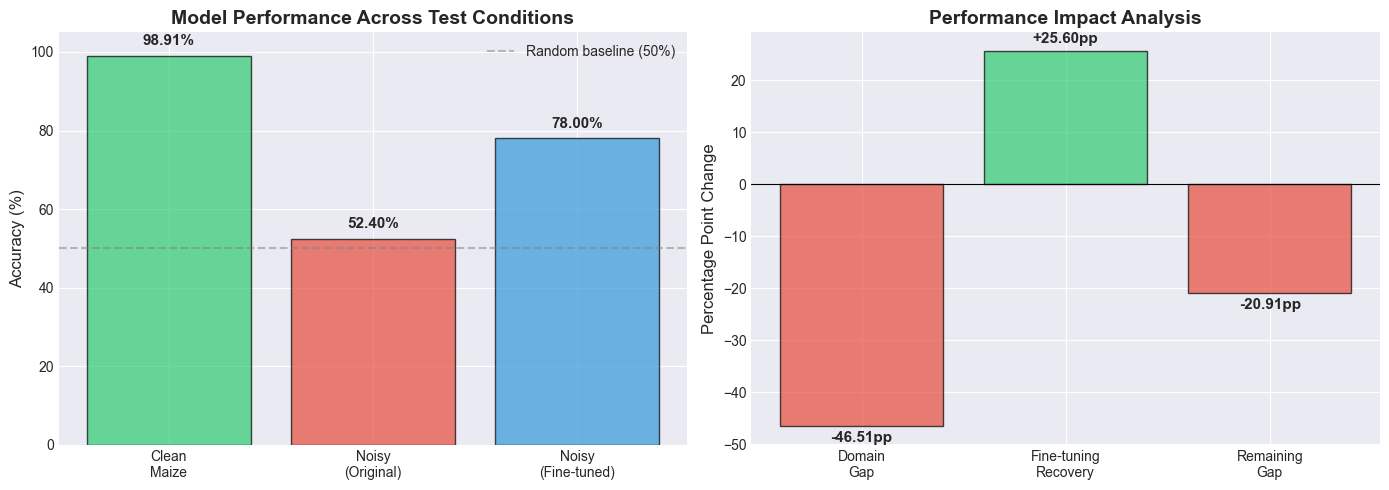

Visualization complete


In [52]:
# Create comparison visualizations

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart comparison
test_sets = ['Clean\nMaize', 'Noisy\n(Original)', 'Noisy\n(Fine-tuned)']
accuracies = [98.91, 52.40, 78.00]
colors = ['#2ecc71', '#e74c3c', '#3498db']

bars = ax1.bar(test_sets, accuracies, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Model Performance Across Test Conditions', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 105)
ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random baseline (50%)')
ax1.legend()

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Performance changes
changes = ['Domain\nGap', 'Fine-tuning\nRecovery', 'Remaining\nGap']
values = [-46.51, 25.60, -20.91]
change_colors = ['#e74c3c' if v < 0 else '#2ecc71' for v in values]

bars2 = ax2.bar(changes, values, color=change_colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Percentage Point Change', fontsize=12)
ax2.set_title('Performance Impact Analysis', fontsize=14, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Add value labels
for bar, val in zip(bars2, values):
    height = bar.get_height()
    va = 'bottom' if height > 0 else 'top'
    offset = 1 if height > 0 else -1
    ax2.text(bar.get_x() + bar.get_width()/2., height + offset,
             f'{val:+.2f}pp', ha='center', va=va, fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("Visualization complete")

In [56]:
# Generate detailed evaluation metrics for all test scenarios
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Define ALL paths
MODEL_PATH = BASE_DIR / "models"
NOISY_TEST_DIR = PROCESSED_DIR / "noisy_test"

# Load fine-tuned model, I am not adding both
model_original = load_model(MODEL_PATH / "mobilenetv2_maize.h5")
model_finetuned = load_model(MODEL_PATH / "mobilenetv2_maize_finetuned.h5")

IMG_SIZE = 224
BATCH_SIZE = 32

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup generators for all three test scenarios
clean_test_gen = test_datagen.flow_from_directory(
    CLEAN_MAIZE_PROCESSED / "test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

noisy_test_gen = test_datagen.flow_from_directory(
    NOISY_TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class names
class_names = list(clean_test_gen.class_indices.keys())
print(f"Classes: {class_names}\n")

# Function to get predictions and generate metrics
#this one is giving issues
def evaluate_and_plot(generator, model, title):
    predictions = model.predict(generator, verbose=0) 
    y_pred = np.argmax(predictions, axis=1)
    y_true = generator.classes
    
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    
    return cm, report, y_true, y_pred

print("Generating metrics for all test scenarios. Please run the next cell")

Found 92 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Classes: ['MLB', 'MSV']

Generating metrics for all test scenarios. Please run the next cell


In [57]:
# Load BOTH models first
model_original = load_model(MODEL_PATH / "mobilenetv2_maize.h5")
model_finetuned = load_model(MODEL_PATH / "mobilenetv2_maize_finetuned.h5")

# Setup generators
clean_test_gen = test_datagen.flow_from_directory(
    CLEAN_MAIZE_PROCESSED / "test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

noisy_test_gen = test_datagen.flow_from_directory(
    NOISY_TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

preprocessed_test_gen = test_datagen.flow_from_directory(
    PREPROCESSED_TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluate all scenarios
print("SCENARIO 1: Clean Test Set (Original Model - Baseline)")
cm_clean, report_clean, _, _ = evaluate_and_plot(clean_test_gen, model_original, "Clean")
print(report_clean)

print("\nSCENARIO 2: Noisy Test Set (Original Model)")
cm_noisy_orig, report_noisy_orig, _, _ = evaluate_and_plot(noisy_test_gen, model_original, "Noisy Original")
print(report_noisy_orig)

print("\nSCENARIO 3: Preprocessed Noisy Test Set (Original Model)")
cm_preprocessed, report_preprocessed, _, _ = evaluate_and_plot(preprocessed_test_gen, model_original, "Preprocessed")
print(report_preprocessed)

print("\nSCENARIO 4: Noisy Test Set (Fine-tuned Model)")
cm_noisy_finetuned, report_noisy_finetuned, _, _ = evaluate_and_plot(noisy_test_gen, model_finetuned, "Noisy Finetuned")
print(report_noisy_finetuned)

Found 92 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
SCENARIO 1: Clean Test Set (Original Model - Baseline)
              precision    recall  f1-score   support

         MLB     0.9787    1.0000    0.9892        46
         MSV     1.0000    0.9783    0.9890        46

    accuracy                         0.9891        92
   macro avg     0.9894    0.9891    0.9891        92
weighted avg     0.9894    0.9891    0.9891        92


SCENARIO 2: Noisy Test Set (Original Model)
              precision    recall  f1-score   support

         MLB     0.5783    0.3200    0.4120       150
         MSV     0.5300    0.7667    0.6267       150

    accuracy                         0.5433       300
   macro avg     0.5541    0.5433    0.5194       300
weighted avg     0.5541    0.5433    0.5194       300


SCENARIO 3: Preprocessed Noisy Test Set (Original Model)
              precision    recall  f1-score   support

         ML

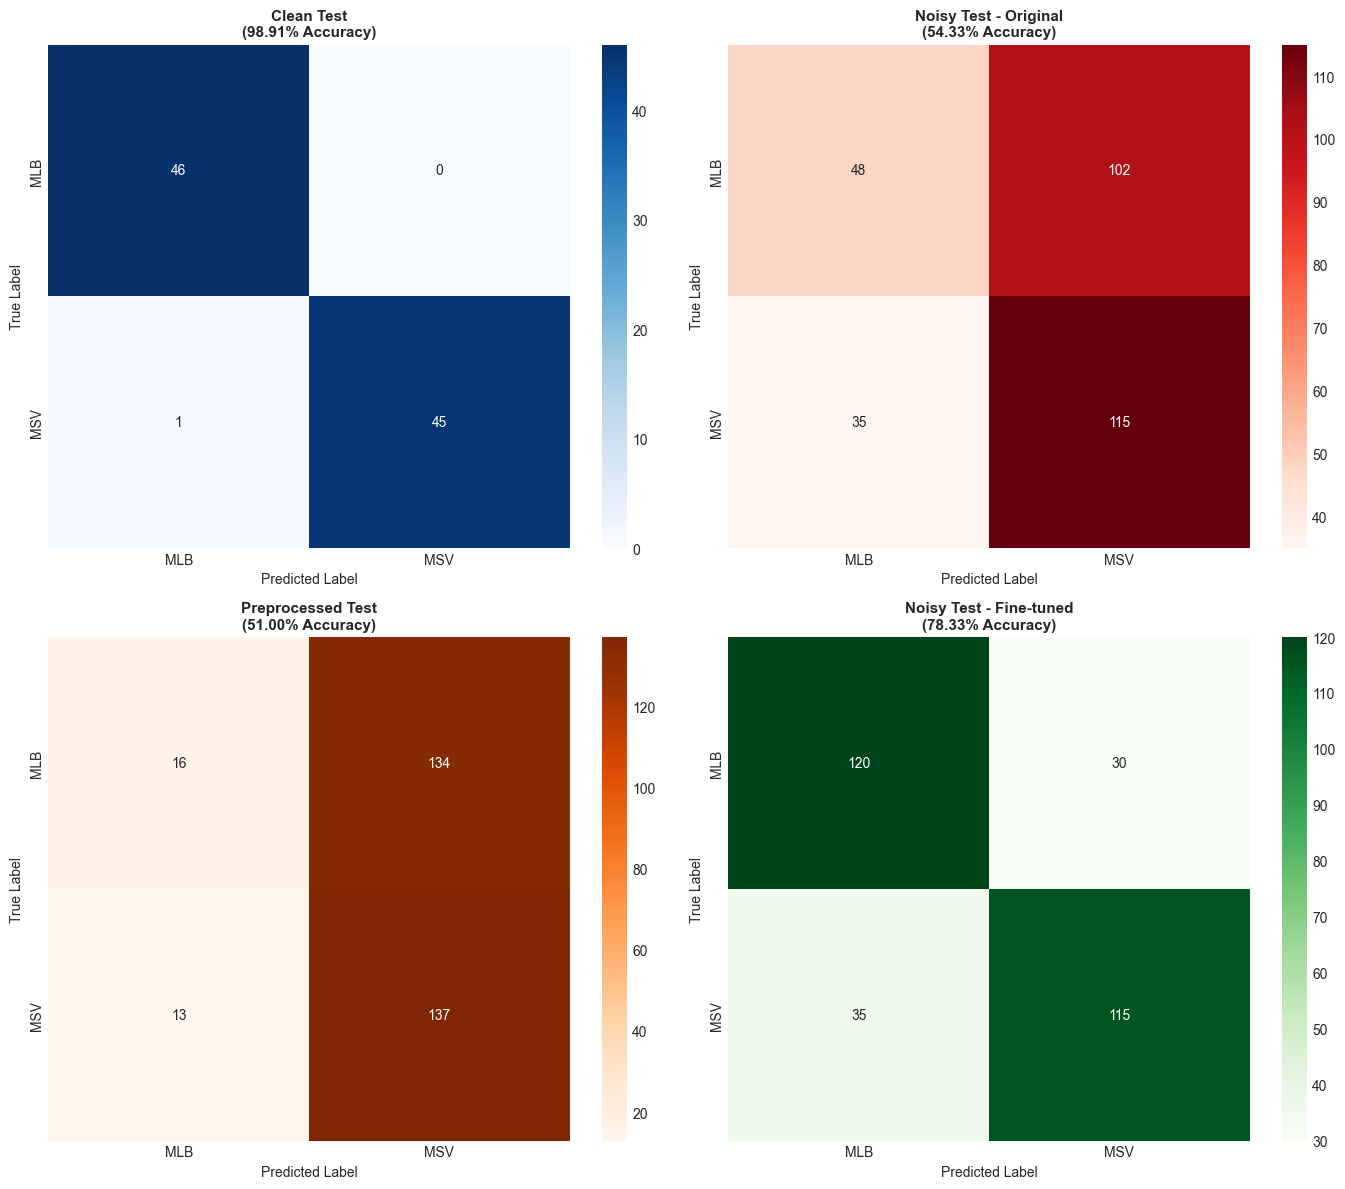

In [59]:
# Visualize all scenarios with CORRECT numbers
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Clean (original model)
sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
axes[0,0].set_title('Clean Test\n(98.91% Accuracy)', fontsize=11, fontweight='bold')
axes[0,0].set_ylabel('True Label', fontsize=10)
axes[0,0].set_xlabel('Predicted Label', fontsize=10)

# Noisy original (original model)
sns.heatmap(cm_noisy_orig, annot=True, fmt='d', cmap='Reds',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0,1])
axes[0,1].set_title('Noisy Test - Original\n(54.33% Accuracy)', fontsize=11, fontweight='bold')
axes[0,1].set_ylabel('True Label', fontsize=10)
axes[0,1].set_xlabel('Predicted Label', fontsize=10)

# Preprocessed (original model)
sns.heatmap(cm_preprocessed, annot=True, fmt='d', cmap='Oranges',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1,0])
axes[1,0].set_title('Preprocessed Test\n(51.00% Accuracy)', fontsize=11, fontweight='bold')
axes[1,0].set_ylabel('True Label', fontsize=10)
axes[1,0].set_xlabel('Predicted Label', fontsize=10)

# Fine-tuned (fine-tuned model)
sns.heatmap(cm_noisy_finetuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1,1])
axes[1,1].set_title('Noisy Test - Fine-tuned\n(78.33% Accuracy)', fontsize=11, fontweight='bold')
axes[1,1].set_ylabel('True Label', fontsize=10)
axes[1,1].set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.show()